# 5. Regularized Linear Regression and Bias vs. Variance

- 작성자: [JWarmenhoven's Exercise 5](https://nbviewer.jupyter.org/github/JWarmenhoven/Coursera-Machine-Learning/blob/master/notebooks/Programming%20Exercise%205%20-%20Regularized%20Linear%20Regression%20and%20Bias%20v.s.%20Variance.ipynb)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline
import seaborn as sns
sns.set_context("notebook")
sns.set_style("white")

loading

In [3]:
data = loadmat("/content/drive/My Drive/study/ML(Andrew Ng)/data/ex5data1.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [5]:
y_train = data['y']
X_train = np.c_[np.ones_like(data['X']), data['X']]

yval = data["yval"]
Xval = np.c_[np.ones_like(data["Xval"]), data["Xval"]]

In [6]:
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}",
      f"Xval: {Xval.shape}, yval: {yval.shape}", sep = "\n")

X_train: (12, 2), y_train: (12, 1)
Xval: (21, 2), yval: (21, 1)


### Regularized Linear Regression

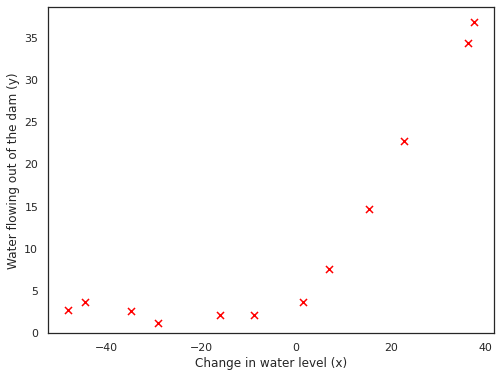

In [9]:
plt.figure(figsize = (8, 6))
plt.scatter(X_train[:, 1], y_train, s = 50, c = 'r', marker = 'x', linewidths = 1)
plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.ylim(0)
plt.show()

figure size에 대해서 RStudio처럼 option으로 고정시키는 방법이 있을 텐데..

Regularized Cost function

In [17]:
def linearRegCostFunction(theta, X, y, reg):
  m = y.size
  h = X.dot(theta)
  J = 1/(2*m) * np.sum(np.square(h - y)) + (reg/2*m) * np.sum(np.square(theta[1:]))
  return(J)

Gradient Descent

In [11]:
def lrgradientReg(theta, X, y, reg):
  m = y.size
  h = X.dot(theta.reshape(-1, 1))
  grad = (1/m) * (X.T.dot(h - y)) + (reg/m) * np.r_[[[0]], theta[1:].reshape(-1, 1)]
  return(grad.flatten())

In [18]:
initial_theta = np.ones((X_train.shape[1], 1))
cost = linearRegCostFunction(initial_theta, X_train, y_train, 0)
gradient = lrgradientReg(initial_theta, X_train, y_train, 0)

In [19]:
print("cost {}".format(cost), "gradient {}".format(gradient), sep = "\n")

cost 303.9515255535976
gradient [-15.30301567 598.16741084]


In [20]:
def trainLinearReg(X, y, reg):
  initial_theta = np.array([[15], [15]])
  res = minimize(linearRegCostFunction, initial_theta, args = (X, y, reg), method = None,
                 jac = lrgradientReg, options = {"maxiter": 5000})
  return(res)

In [22]:
fit = trainLinearReg(X_train, y_train, 0)
print(fit)

      fun: 1604.4002999186632
 hess_inv: array([[1.03142187, 0.00617881],
       [0.00617881, 0.001215  ]])
      jac: array([ 3.4243719e-12, -5.7042134e-10])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([13.08790351,  0.36777923])

생각보다 적합이 잘 된 듯 보인다?

#### Comparison
- coefficients and cost obtained with LinearRegression in Scikit-learn

In [23]:
regr = LinearRegression(fit_intercept = False)
regr.fit(X_train, y_train.ravel())

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

여기서 얘기하는 fit_intercept가 모델에 대한 원점 회귀, 상수항 제거의 얘기가 아니네? 적합 알고리즘에 대한 원점 적합을 이야기하는 건가?

In [24]:
print(regr.coef_, linearRegCostFunction(regr.coef_, X_train, y_train, 0), sep = "\n")

[13.08790351  0.36777923]
1604.4002999211034


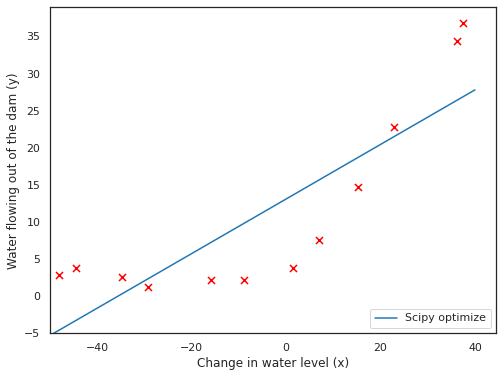

In [28]:
plt.figure(figsize = (8, 6))
plt.plot(np.linspace(-50, 40), (fit.x[0] + (fit.x[1] * np.linspace(-50, 40))),
         label = "Scipy optimize")
plt.scatter(X_train[:, 1], y_train, s = 50, c = 'r', marker = 'x', linewidths = 1)

plt.xlabel("Change in water level (x)")
plt.xlim(-50)
plt.ylabel("Water flowing out of the dam (y)")
plt.ylim(-5)
plt.legend(loc = 4)
plt.show()

흠. 역시 이래서 데이터 산포도 먼저 봐야 하는 거다.<br />해당 데이터의 X와 Y의 관계는 처음부터 선형과는 거리가 멀었던 것.

In [31]:
def learningCurve(X, y, Xval, yval, reg):
  m = y.size
  error_train = np.zeros((m, 1))
  error_val = np.zeros((m, 1))
  
  for i in np.arange(m):
    res = trainLinearReg(X[:i+1], y[:i+1], reg)
    error_train[i] = linearRegCostFunction(res.x, X[:i+1], y[:i+1], reg)
    error_val[i] = linearRegCostFunction(res.x, Xval, yval, reg)
  
  return(error_train, error_val)

In [32]:
t_error, v_error = learningCurve(X_train, y_train, Xval, yval, 0)

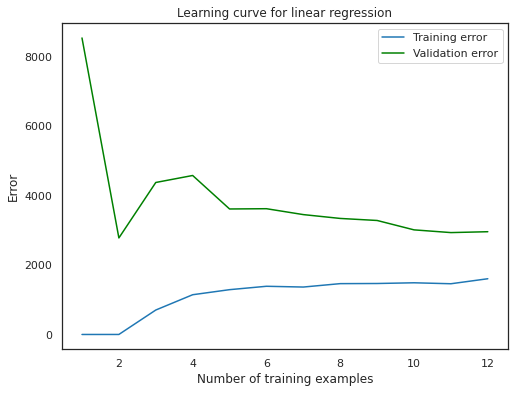

In [41]:
plt.figure(figsize = (8, 6))
plt.plot(np.arange(1, 13), t_error, label = "Training error")
plt.plot(np.arange(1, 13), v_error, label = "Validation error", c = 'g')

plt.title("Learning curve for linear regression")
plt.xlabel("Number of training examples")
plt.ylabel("Error")
plt.legend()
plt.show()

왠지 과대적합의 위험성을 보여주는 듯한 모양새, 물론 지금은 training N의 크기를 키운 것뿐이지만, 그냥 그림의 모양이 그렇다고.

#### Polynomial regression (Scikit-learn)

In [36]:
poly = PolynomialFeatures(degree = 8)
X_train_poly = poly.fit_transform(X_train[:, 1].reshape(-1, 1))

In [37]:
regr2 = LinearRegression()
regr2.fit(X_train_poly, y_train)

regr3 = Ridge(alpha = 20)
regr3.fit(X_train_poly, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.35663e-26): result may not be accurate.
  overwrite_a=True).T


Ridge(alpha=20, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [38]:
plot_x = np.linspace(-60, 45)
plot_y = regr2.intercept_ + np.sum(regr2.coef_ * poly.fit_transform(plot_x.reshape(-1, 1)), axis = 1)
plot_y2 = regr3.intercept_ + np.sum(regr3.coef_ * poly.fit_transform(plot_x.reshape(-1, 1)), axis = 1)

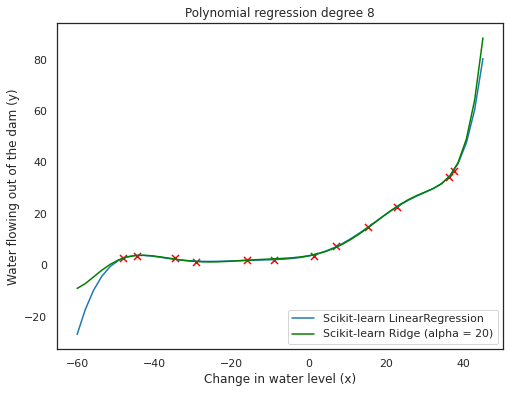

In [42]:
plt.figure(figsize = (8, 6))
plt.plot(plot_x, plot_y, label = "Scikit-learn LinearRegression")
plt.plot(plot_x, plot_y2, label = "Scikit-learn Ridge (alpha = {})".format(regr3.alpha), c = 'g')

plt.scatter(X_train[:, 1], y_train, s = 50, c = 'r', marker = 'x', linewidths = 1)

plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.title("Polynomial regression degree 8")
plt.legend(loc = 4)
plt.show()

polynomial을 통해 데이터를 설명하게 된 건 좋지만, 그림의 상황은 과대적합을 의심할 수밖에 없어보인다.

일단 데이터의 크기가 작다.

또, 현재 데이터의 범위를 벗어나는 값에 대해, 특히 작은 값에 대해 정규화를 한 것도 안 한 것도 상이한 형태를 보이므로 이렇다할 지식으로 만들긴 어려워 보인다.